In [ ]:
#Install cpu only version of torchvision, for accessing MNIST dataset
#GPU version may have compatibility issues with JAX
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu  

In [2]:
import jax.numpy as jnp
from jax.nn import log_softmax,one_hot
from jax import grad,vmap
import jax
#jax.config.update('jax_default_matmul_precision', 'bfloat16')
import torchvision

def get_dataset_torch():
    mnist = {
        'train': torchvision.datasets.MNIST('./data', train=True, download=True),
        'test': torchvision.datasets.MNIST('./data', train=False, download=True)
    }

    ds = {}

    for split in ['train', 'test']:
        ds[split] = {
            'image': mnist[split].data.numpy(),
            'label': mnist[split].targets.numpy()
        }

        # cast from np to jnp and rescale the pixel values from [0,255] to [0,1]
        ds[split]['image'] = jnp.float32(ds[split]['image']) / 255.0
        ds[split]['label'] = jnp.int32(ds[split]['label'])

        # torchvision returns shape (B, 28, 28).
        # hence, append the trailing channel dimension.
        ds[split]['image'] = jnp.expand_dims(ds[split]['image'], 3)

    return ds['train'], ds['test']

train, test = get_dataset_torch()
train['image']=train['image'].reshape([60000,28*28])
train['image']=jnp.concatenate((train['image'],jnp.float32(jnp.ones([60000,1]))),1)
train['label']=jnp.float32(one_hot(train['label'],10))
test['image']=test['image'].reshape([10000,28*28])
test['image']=jnp.concatenate((test['image'],jnp.float32(jnp.ones([10000,1]))),1)
test['label']=jnp.float32(one_hot(test['label'],10))

In [3]:
@jax.jit
def lpost(beta):
    return jnp.sum(jnp.square(beta))*10/2-(log_softmax(train['image']@beta.reshape(785,10))*train['label']).sum()
grad_lpost=jax.jit(grad(lpost))

import scipy.optimize
optim_res=scipy.optimize.minimize(lpost,jnp.zeros(7850),method="L-BFGS-B",jac=grad_lpost)
beta_min=optim_res.x

def hvp(x, v):
    return jax.grad(lambda x: jnp.vdot(grad_lpost(x), v))(x)
def hvp_beta_min(v):
    return hvp(beta_min, v)
vhvp_beta_min=vmap(hvp_beta_min)

from jax.lax import dynamic_update_slice
import numpy as np
ID=jnp.identity(7850)
nbeta=7850
hess_min=jnp.zeros([7850,7850])
vmap_size=25

for it in range(7850//vmap_size):
    slice1=ID[(it*vmap_size):((it+1)*vmap_size),:]
    hess1=vhvp_beta_min(slice1)
    hess_min=dynamic_update_slice(hess_min,hess1,(it*vmap_size,0))

hess_min=(hess_min+jnp.transpose(hess_min))/2
ehess_min,evhess_min=jnp.linalg.eigh(hess_min)
sqrt_D = jnp.diag(jnp.sqrt(ehess_min))
invsqrt_D = jnp.diag(jnp.pow(ehess_min,-0.5))

inv_sqrt_hess_min =  jnp.asarray(evhess_min @ invsqrt_D @ evhess_min.T)

def lpost_precond(beta_precond):
    beta=beta_precond.reshape([1,nbeta])@inv_sqrt_hess_min+beta_min.reshape([1,nbeta])
    return jnp.sum(jnp.square(beta))*10/2-(log_softmax(train['image']@beta.reshape(785,10))*train['label']).sum()
grad_lpost_precond=grad(lpost_precond)
vmap_grad_lpost_precond=vmap(grad_lpost_precond)

def prob_precond(beta_precond):
    beta=beta_precond.reshape([1,nbeta])@inv_sqrt_hess_min+beta_min.reshape([1,nbeta])
    return jnp.exp((log_softmax(test['image']@beta.reshape(785,10))*test['label']).sum(axis=1))

prob_ind=np.asarray((prob_precond(jnp.zeros(nbeta))>0.1)*(prob_precond(jnp.zeros(nbeta))<0.9))
dim_prob_ind=np.sum(prob_ind)
test_image_ind=jnp.asarray(test['image'][prob_ind,:])
test_label_ind=jnp.asarray(test['label'][prob_ind,:])

def test_function_precond(beta_precond):
    beta=(beta_precond.reshape([1,nbeta])@inv_sqrt_hess_min+beta_min.reshape([1,nbeta])).reshape([nbeta,])
    return jnp.concatenate([beta,(jnp.exp((log_softmax(test_image_ind@beta.reshape(785,10))*test_label_ind).sum(axis=1)))])

vmap_test_function_precond=vmap(test_function_precond)

In [4]:
from methods.multilevel_ubu import multilevel_ubu,vmap_generate_multilevels,vmap_multilevel_ubu
from jax import random

test_dim=dim_prob_ind+nbeta
M=1.0
m=1.0
r=4.0
c=1.0/16
maxlevel=8
max_parallel_chain=32
niter=400
burnin=40
rep=128
h=jnp.array(1.0)/jnp.sqrt(M)
gam=jnp.sqrt(m)

key=random.key(34556674)
chunk_size=16
keys=random.split(key,chunk_size)

res=vmap_multilevel_ubu(niter,burnin,rep,h,gam, vmap_grad_lpost_precond, vmap_test_function_precond, r,c,nbeta,test_dim,beta_min,maxlevel,max_parallel_chain, keys, chunk_size)

#_=multilevel_ubu(niter,burnin,rep,h,gam, vmap_grad_lpost_precond, vmap_test_function_precond, r,c,nbeta,test_dim,beta_min,maxlevel,max_parallel_chain, 4,key)

[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2]
Lev: 0 / 1 xn/x2n error: VmapTracer<float32[]>
h: 1.0 h/2: 0.5
Lev: 1 / 2 xn/x2n error: VmapTracer<float32[]>
h: 0.5 h/2: 0.25
maxmultilevels: 5
multilevels: 2
Lev: 2 / 3 ...
hm: 0.25
Multi error: VmapTracer<float32[6]>


In [5]:
import time
key=random.key(3563283)
par_runs=16*4
keys=random.split(key,par_runs)
start_time=time.time()
res=vmap_multilevel_ubu(niter,burnin,rep,h,gam, vmap_grad_lpost_precond, vmap_test_function_precond, r,c,nbeta,test_dim,beta_min,maxlevel,max_parallel_chain, keys, chunk_size)
end_time=time.time()
total_time=end_time-start_time


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2]
Lev: 0 / 1 xn/x2n error: VmapTracer<float32[]>
h: 1.0 h/2: 0.5
Lev: 1 / 2 xn/x2n error: VmapTracer<float32[]>
h: 0.5 h/2: 0.25
maxmultilevels: 5
multilevels: 0
Lev: 2 / 3 ...
hm: 0.25
Multi error: VmapTracer<float32[6]>
Lev: 0 / 1 xn/x2n error: VmapTracer<float32[]>
h: 1.0 h/2: 0.5
Lev: 1 / 2 xn/x2n error: VmapTracer<float32[]>
h: 0.5 h/2: 0.25
maxmultilevels: 5
multilevels: 0
Lev: 2 / 3 ...
hm: 0.25
Multi error: VmapTracer<float32[6]>
Lev: 0 / 1 xn/x2n error: VmapTracer<float32[]>
h: 1.0 h/2: 0.5
Lev: 1 / 2 xn/x2n error: VmapTracer<float32[]>
h: 0.5 h/2: 0.25
maxmultilevels: 5
multilevels: 0
Lev: 2 / 3 ...
hm: 0.25
Multi error: VmapTracer<float32[6]>
Lev: 0 / 1 xn/x2n error: VmapTracer<float32[]>
h: 1.0 h/2: 0.5
Lev: 1 / 2 xn/x2n error: VmapTracer<float32[]>
h: 0.5 h/2: 0.25
maxmultilevels: 5
multilevels: 2
Lev: 2 / 3 ...
hm: 0.25
Multi error: VmapTracer<f

In [6]:
from methods.process_res_multi import process_res_multi
ess,grad_per_ess=process_res_multi(res,jnp.arange(par_runs))
print("max grad per ess coordinates:",jnp.max(grad_per_ess[:nbeta]))
print("min ess coordinates:",jnp.min(ess[:nbeta]))
print("ess/sec for UBUBU coordinates:",jnp.min(ess[:nbeta])/(total_time/par_runs))

print("max grad per ess prediction:",jnp.max(grad_per_ess[nbeta:]))
print("min ess prediction:",jnp.min(ess[nbeta:]))
print("ess/sec for UBUBU prediction:",jnp.min(ess[nbeta:])/(total_time/par_runs))



mean repruns: [1.280e+02 8.000e+00 2.000e+00 1.000e+00 1.250e-01 3.125e-02 0.000e+00
 0.000e+00 0.000e+00]
test_mean_var: 3.031542e-06
ngradtot: 83765.0
test_mean_lev_0_comp1: 8.115014e-05
max_test_mean_lev_0_var: 3.1846926e-06
test_squaremean_lev_0_comp1: 0.083870746
blockstart: [  0 128 136 138 139 140 141 142 143]
blockend: [128 136 138 139 140 141 142 143 144]
maxlevel: 8
lev: 1
max_lev_test_mean_diff: 0.011905665
max_lev_test_mean_diff_var: 7.6185506e-07 repruns[lev+1,0]: 8
lev: 2
max_lev_test_mean_diff: 0.002900206
max_lev_test_mean_diff_var: 2.429867e-07 repruns[lev+1,0]: 2
lev: 3
max_mean_diff_lev: 0.0009292724
max_test_mean_var: 5.91232e-08
test_post_var: 0.10005418
median test mean var: 2.3019966e-06
median test post var: 0.059134945
min test post var: 0.0010888577
min_ess: 23108.988
median_ess: 25738.81
maxgradperess: 3.6247802
mediangradperess: 3.2544239
test_mean: 0.00013797721
test_squaremean: 0.100054204
max grad per ess coordinates: 3.4464767
min ess coordinates: 24304.

In [ ]:
from methods.bootstrap_res import bootstrap_res
bootstrap_samp=256
key=random.key(23847)
keys=random.split(key,bootstrap_samp)
grad_per_ess_arr,max_grad_per_ess,max_grad_per_ess2,sd,sdmax,sdmax2=bootstrap_res(res,bootstrap_samp,par_runs,nbeta,process_res_multi,keys)
import pickle
with open('./output/MNIST_UBUBU_precond.pkl', 'wb') as file:
    pickle.dump((ess, grad_per_ess,grad_per_ess_arr,max_grad_per_ess,max_grad_per_ess2,sd,sdmax,sdmax2),file)


mean repruns: VmapTracer<float32[9]>
test_mean_var: VmapTracer<float32[]>
ngradtot: 83765.0
test_mean_lev_0_comp1: VmapTracer<float32[]>
max_test_mean_lev_0_var: VmapTracer<float32[]>
test_squaremean_lev_0_comp1: VmapTracer<float32[]>
blockstart: [  0 128 136 138 139 140 141 142 143]
blockend: [128 136 138 139 140 141 142 143 144]
maxlevel: 8
lev: 1
max_lev_test_mean_diff: VmapTracer<float32[]>
max_lev_test_mean_diff_var: VmapTracer<float32[]> repruns[lev+1,0]: VmapTracer<int32[]>
lev: 2
max_lev_test_mean_diff: VmapTracer<float32[]>
max_lev_test_mean_diff_var: VmapTracer<float32[]> repruns[lev+1,0]: VmapTracer<int32[]>
lev: 3
max_mean_diff_lev: VmapTracer<float32[]>
max_test_mean_var: VmapTracer<float32[]>
test_post_var: VmapTracer<float32[]>
median test mean var: VmapTracer<float32[]>
median test post var: VmapTracer<float32[]>
min test post var: VmapTracer<float32[]>
min_ess: VmapTracer<float32[]>
median_ess: VmapTracer<float32[]>
maxgradperess: VmapTracer<float32[]>
mediangradperess

In [1]:
import pickle
with open('./output/MNIST_UBUBU_precond.pkl', 'rb') as file:
    (ess, grad_per_ess,grad_per_ess_arr,max_grad_per_ess,max_grad_per_ess2,sd,sdmax,sdmax2)=pickle.load(file)
print("Bootstrap sd for max grad per ess coordinates:", sdmax)
print("Bootstrap sd for max grad per ess prediction:", sdmax2)


Bootstrap sd for max grad per ess coordinates: 0.1154138
Bootstrap sd for max grad per ess prediction: 0.09357397


<Figure size 640x480 with 0 Axes>

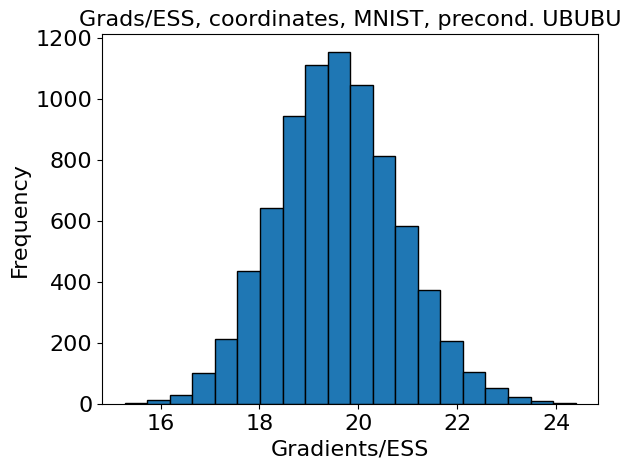

In [12]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
fig, ax = plt.subplots()
ax.set_xlabel("Gradients/ESS", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
ax.set_title("Grads/ESS, coordinates, MNIST, precond. UBUBU",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
nbeta=7850
plt.hist(grad_per_ess[0:nbeta],bins=20,histtype='bar',edgecolor='black')
plt.savefig("./output/UBUBU_MNIST_precond_coordinates.pdf", format="pdf",bbox_inches='tight') 
plt.show()

<Figure size 640x480 with 0 Axes>

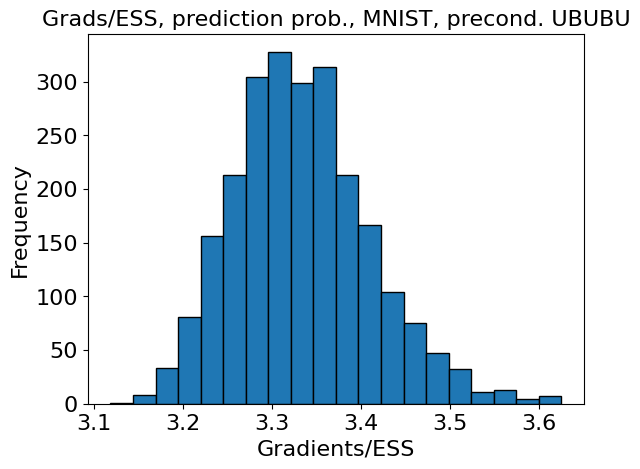

In [6]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
fig, ax = plt.subplots()
ax.set_xlabel("Gradients/ESS", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
ax.set_title("Grads/ESS, prediction prob., MNIST, precond. UBUBU",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.hist(grad_per_ess[nbeta:],bins=20,histtype='bar',edgecolor='black')
plt.savefig("./output/UBUBU_MNIST_precond_prediction_prob.pdf", format="pdf",bbox_inches='tight') 
plt.show()

In [23]:
from methods.hmc import hmcsampler,vmap_hmcsampler
from methods.process_res_hmc import process_res_hmc
from jax import random
import time

niter=400
burnin=40
partial=0.7
numsteps=10
test_dim=nbeta+dim_prob_ind
nbeta=7850
par_runs=512
chunk_size=32
M=1.0
m=1.0
h=jnp.array(0.1)/jnp.sqrt(M)
key=random.key(12389)
keys=random.split(key,par_runs)
x0=jnp.ones([rep,1])@beta_min.reshape([1,nbeta])+random.normal(key,[par_runs,nbeta])@inv_sqrt_hess_min


In [16]:
_=vmap_hmcsampler(niter,burnin,numsteps,partial,h,lpost_precond,grad_lpost_precond,test_function_precond,test_dim,x0,keys[0:chunk_size],chunk_size)

In [17]:
start_time=time.time()
res=vmap_hmcsampler(niter,burnin,numsteps,partial,h,lpost_precond,grad_lpost_precond,test_function_precond,test_dim,x0,keys,chunk_size)
end_time=time.time()
total_time=end_time-start_time
print("Total time:", total_time)

Total time: 419.293429851532


In [24]:
print("mean acceptance rate:", res[2].mean())
ess,grad_per_ess=process_res_hmc(res,jnp.arange(rep))

print("max grad per ess coordinates:",jnp.max(grad_per_ess[:nbeta]))
print("min ess coordinates:",jnp.min(ess[:nbeta]))
print("ess/sec for RHMC coordinates:",jnp.min(ess[:nbeta])/(total_time/par_runs))

print("max grad per ess prediction:",jnp.max(grad_per_ess[nbeta:]))
print("min ess prediction:",jnp.min(ess[nbeta:]))
print("ess/sec for RHMC prediction:",jnp.min(ess[nbeta:])/(total_time/par_runs))

mean acceptance rate: 0.85721767
max grad per ess coordinates: 24.391476
min ess coordinates: 180.39088
ess/sec for RHMC coordinates: 220.27565
max grad per ess prediction: 29.176804
min ess prediction: 150.80473
ess/sec for RHMC prediction: 184.14795


In [25]:
from methods.bootstrap_res import bootstrap_res
bootstrap_samp=1024
chunk_size=64
key=random.key(23847)
keys=random.split(key,bootstrap_samp)
grad_per_ess_arr,max_grad_per_ess,max_grad_per_ess2,sd,sdmax,sdmax2=bootstrap_res(res,bootstrap_samp,rep,process_res_hmc,chunk_size,nbeta,keys)


In [26]:
import pickle
with open("./output/MNIST_RHMC_precond.pkl", "wb") as file:
    pickle.dump((ess, grad_per_ess,grad_per_ess_arr,max_grad_per_ess,max_grad_per_ess2,sd,sdmax,sdmax2),file)

In [8]:
import pickle
with open("./output/MNIST_RHMC_precond.pkl", "rb") as file:
    (ess, grad_per_ess,grad_per_ess_arr,max_grad_per_ess,max_grad_per_ess2,sd,sdmax,sdmax2)=pickle.load(file)

print("Bootstrap sd for max grad per ess coordinates:", sdmax)
print("Bootstrap sd for max grad per ess prediction:", sdmax2)


Bootstrap sd for max grad per ess coordinates: 1.0544857
Bootstrap sd for max grad per ess prediction: 1.6919676


<Figure size 640x480 with 0 Axes>

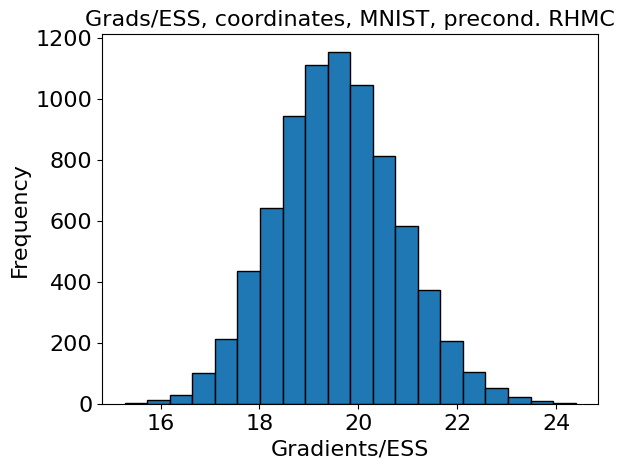

In [10]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
fig, ax = plt.subplots()
ax.set_xlabel("Gradients/ESS", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
ax.set_title("Grads/ESS, coordinates, MNIST, precond. RHMC",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.hist(grad_per_ess[:nbeta],bins=20,histtype='bar',edgecolor='black')
plt.savefig("./output/RHMC_MNIST_precond_coordinates.pdf", format="pdf",bbox_inches='tight') 
plt.show()


<Figure size 640x480 with 0 Axes>

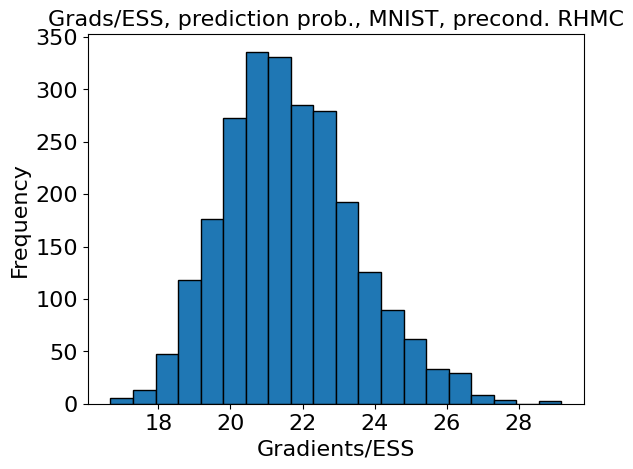

In [11]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
fig, ax = plt.subplots()
ax.set_xlabel("Gradients/ESS", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
ax.set_title("Grads/ESS, prediction prob., MNIST, precond. RHMC",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.hist(grad_per_ess[nbeta:],bins=20,histtype='bar',edgecolor='black')
plt.savefig("./output/RHMC_MNIST_precond_prediction.pdf", format="pdf",bbox_inches='tight') 
plt.show()